In [1]:
# !pip install imutils==0.5.4

In [28]:
from matplotlib import pyplot as plt
from pathlib import Path

import numpy as np

import cv2
from skimage import io

def imshow(np_img, size=(10, 10), is_gray=False):
    plt.figure(figsize=size)
    if is_gray:
        plt.imshow(np_img, cmap='gray', vmin=0, vmax=255)
    else:
        try:
            plt.imshow(cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB))
        except:
            plt.imshow(np_img)
    plt.show()

In [29]:
data_dir = Path('assets')
assert data_dir.exists()

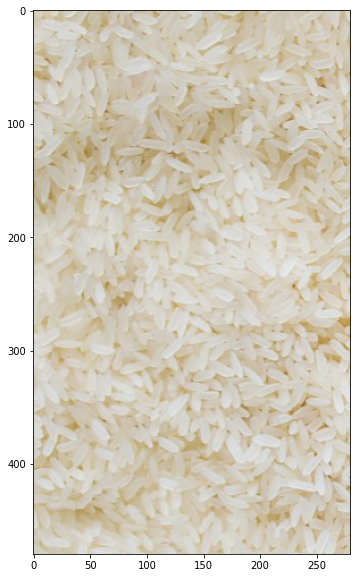

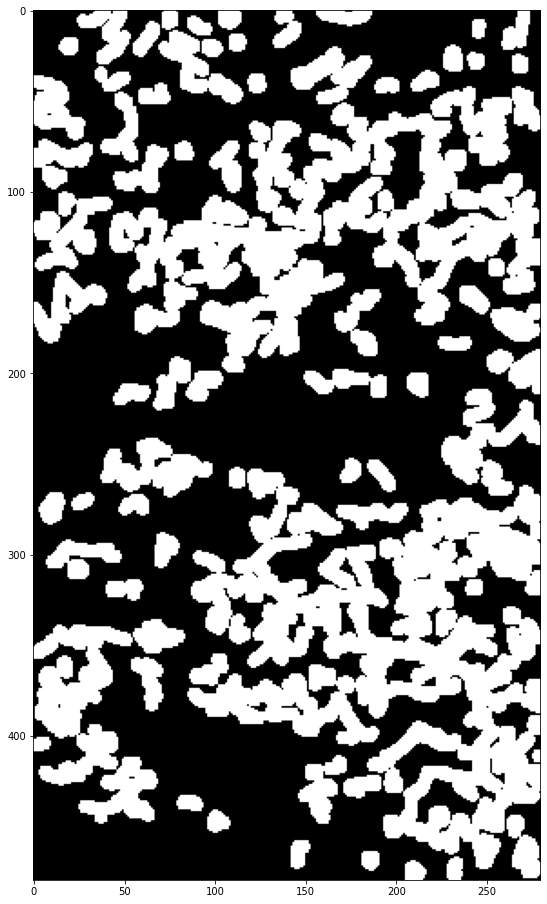

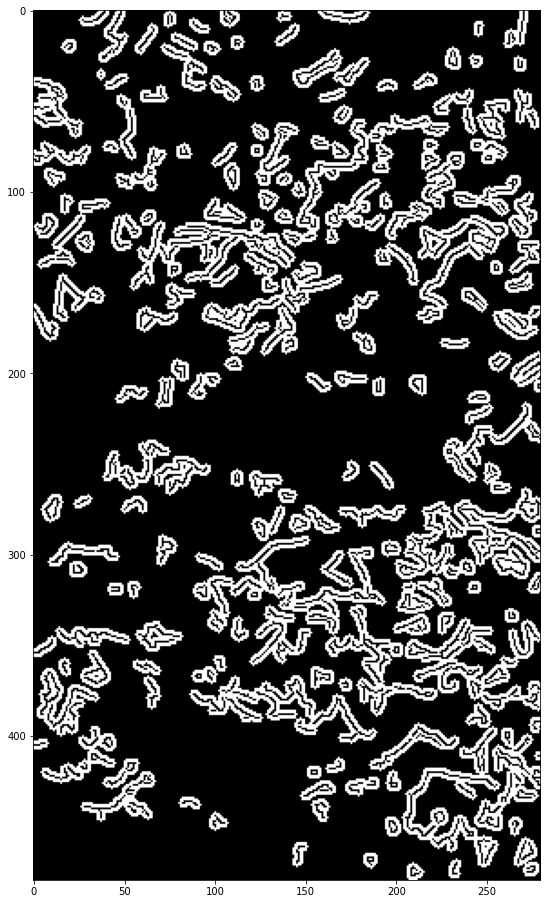

In [76]:
img = cv2.cvtColor(io.imread(data_dir / 'count1.jpg'), cv2.COLOR_BGR2RGB)
shifted = cv2.pyrMeanShiftFiltering(img, 11, 21)

grayscaled = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

edge_img = cv2.Canny(grayscaled, 100, 200)

threshold = cv2.adaptiveThreshold(edge_img, 255,
                          cv2.BORDER_REPLICATE,
                          cv2.THRESH_BINARY_INV, 5, 5)

retval, birnary_threshold = cv2.threshold(threshold, 0, 255, cv2.THRESH_BINARY)

flipped_color = cv2.bitwise_not(birnary_threshold)

kernel = np.ones((3,3), np.uint8) 
flipped_color = cv2.dilate(birnary_threshold, kernel, iterations=1) 

imshow(img)

imshow(flipped_color, (16, 16), True)

imshow(birnary_threshold, (16, 16), True)

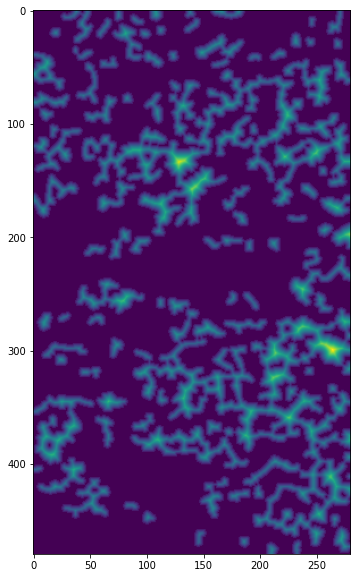

In [77]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

D = ndimage.distance_transform_edt(flipped_color)
imshow(D)

In [71]:
thresh = birnary_threshold#flipped_color

/tmp/ipykernel_92/340777765.py:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=7, labels=thresh)


[INFO] 503 unique segments found


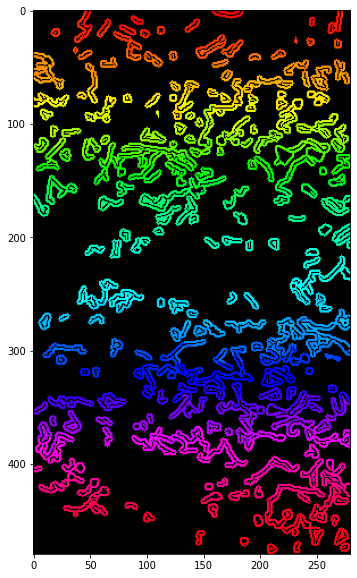

In [72]:
localMax = peak_local_max(D, indices=False, min_distance=7, labels=thresh)
 
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# cvt to BGR for display
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# set bg label to black
labeled_img[label_hue==0] = 0

imshow(labeled_img)

In [73]:
import imutils

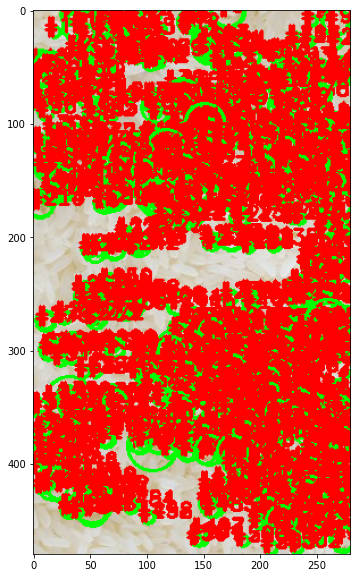

In [74]:
# loop over the unique labels returned by the Watershed
# algorithm
image = img

for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(grayscaled.shape, dtype="uint8")
    mask[labels == label] = 255 
    #cv2_imshow(mask)#[labels == label] = 255   
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
 

imshow(image)

In [75]:
len(np.unique(labels))

504